CGM DATA PREPROCESSING

In [1]:
import csv

input_file_path= '/content/drive/MyDrive/Spotify Project/CGM.txt'
output_csv_path= '/content/drive/MyDrive/Spotify Project/output.csv'

with open(input_file_path, 'r') as text_file, open(output_csv_path, 'w', newline='') as csv_file:
    reader= csv.reader(text_file, delimiter='|')
    header= next(reader)
    csv_writer= csv.writer(csv_file)
    csv_writer.writerow(header)

    for row in reader:
        csv_writer.writerow(row)

print(f'Conversion complete. CSV file saved to: {output_csv_path}')


Conversion complete. CSV file saved to: /content/drive/MyDrive/Spotify Project/output.csv


In [1]:
import pandas as pd
df= pd.read_csv('/content/drive/MyDrive/Spotify Project/output.csv')
df.drop(columns=['DisplayTimeAdjusted', 'DisplayTime'], inplace=True)
df.head()

,DeidentID,RecID,InternalTime,CGM
0,1,1,2013-09-30 00:36:48,194
1,1,2,2013-09-30 00:41:48,204
2,1,3,2013-09-30 00:46:48,201
3,1,4,2013-09-30 00:51:48,204
4,1,5,2013-09-30 00:56:48,200


In [2]:
print(len(df[df.DeidentID==1]))
dfone= df[df.DeidentID==1]
dfone.head()

23994


,DeidentID,RecID,InternalTime,CGM
0,1,1,2013-09-30 00:36:48,194
1,1,2,2013-09-30 00:41:48,204
2,1,3,2013-09-30 00:46:48,201
3,1,4,2013-09-30 00:51:48,204
4,1,5,2013-09-30 00:56:48,200


<ipython-input-23-293f3e726bb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfone['InternalTime'] = pd.to_datetime(dfone['InternalTime'])


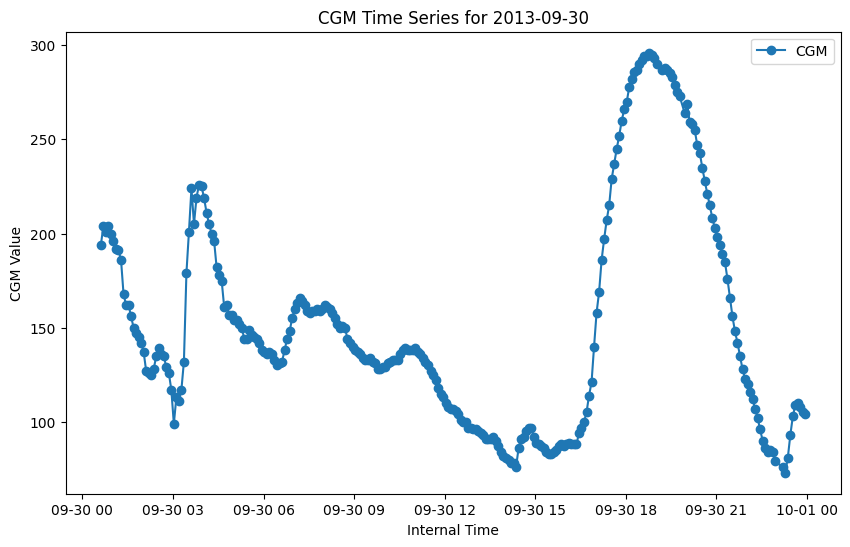

In [23]:
import matplotlib.pyplot as plt
dfone['InternalTime']= pd.to_datetime(dfone['InternalTime'])
selected_date= '2013-09-30'

selected_data= dfone[dfone['InternalTime'].dt.date== pd.to_datetime(selected_date).date()]

plt.figure(figsize=(10, 6))
plt.plot(selected_data['InternalTime'], selected_data['CGM'], marker='o', label='CGM')
plt.xlabel('Internal Time')
plt.ylabel('CGM Value')
plt.title(f'CGM Time Series for {selected_date}')
plt.legend()
plt.show()

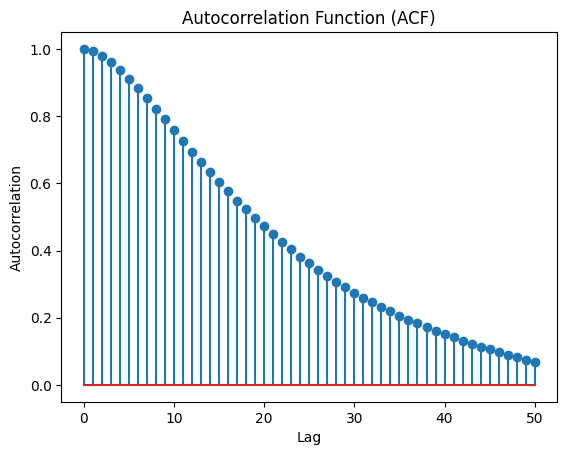

In [7]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

acf_result = sm.tsa.acf(dfone['CGM'], nlags=50)

plt.stem(acf_result)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()


In [8]:
import statsmodels.api as sm

result = sm.tsa.adfuller(dfone['CGM'])

adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

if p_value <= 0.05:
    print("Reject the null hypothesis; the data is stationary.")
else:
    print("Fail to reject the null hypothesis; the data is non-stationary.")


ADF Statistic: -18.330379068788996
p-value: 2.256459343280399e-30
Reject the null hypothesis; the data is stationary.


In [ ]:
dfone['InternalDate']= [str(x) for x in dfone['InternalTime']]
dfone['InternalDate']= [x[0:11] for x in dfone['InternalDate']]
list(dfone['InternalDate'].unique())

TIME SERIES FORECASTING FOR CONTINUOUS DATES

In [4]:
df_cont= dfone.iloc[:7173, :]
dfone_2= df_cont.copy()
print(df_cont.columns)
df_cont.drop(columns=['DeidentID', 'RecID',  'InternalDate'], inplace=True)

Index(['DeidentID', 'RecID', 'InternalTime', 'CGM', 'InternalDate'], dtype='object')

CREATING A WINDOWED DATASET

In [6]:
import numpy as np

window_size = 5
shift = 1
df_cont_cgm=df_cont['CGM']

X = []
y = []
for i in range(0, len(df_cont) - window_size, shift):
    window = df_cont_cgm.iloc[i:i+window_size]
    target = df_cont_cgm.iloc[i+window_size]
    X.append(window)
    y.append(target)

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))


Shape of X: (7168, 5)
Shape of y: (7168,)


TIME SERIES FORECASTING USING LSTM

Results: Test Loss: 27.35538673400879 ; Test MAE: 4.840931415557861

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
import tensorflow.keras.backend as K

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model = Sequential([
    LSTM(units=100, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True),
    LSTM(units=100),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=[root_mean_squared_error])

history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

loss, mae = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)

predictions = model.predict(X_test)

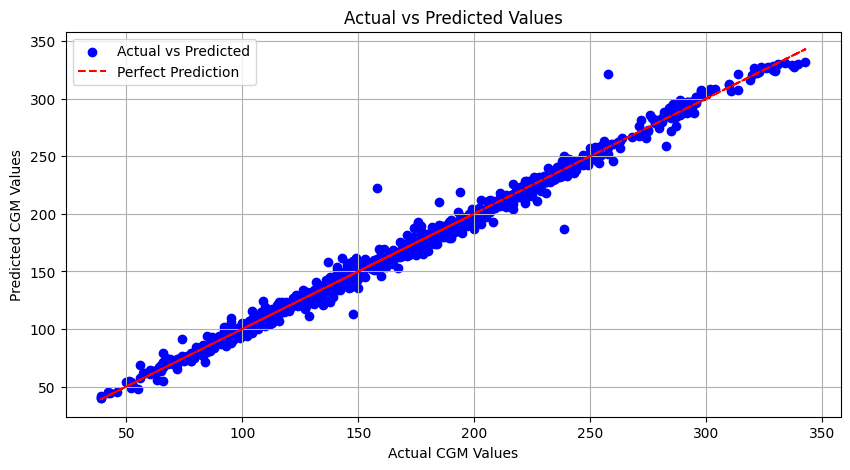

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.scatter(y_test, predictions, color='blue', label='Actual vs Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Perfect Prediction')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual CGM Values')
plt.ylabel('Predicted CGM Values')
plt.legend()
plt.grid(True)
plt.show()

USING BASIC DEEP NEURAL NETWORK

Results: Test Loss: 27.42608070373535 ; Test MSE: 4.850590229034424

In [ ]:
#DNN for continuous dates data

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model = Sequential([
    Dense(units=64, activation='relu', input_shape=(window_size,)),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mse', metrics=[root_mean_squared_error])

history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

loss, mae = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)

predictions = model.predict(X_test)


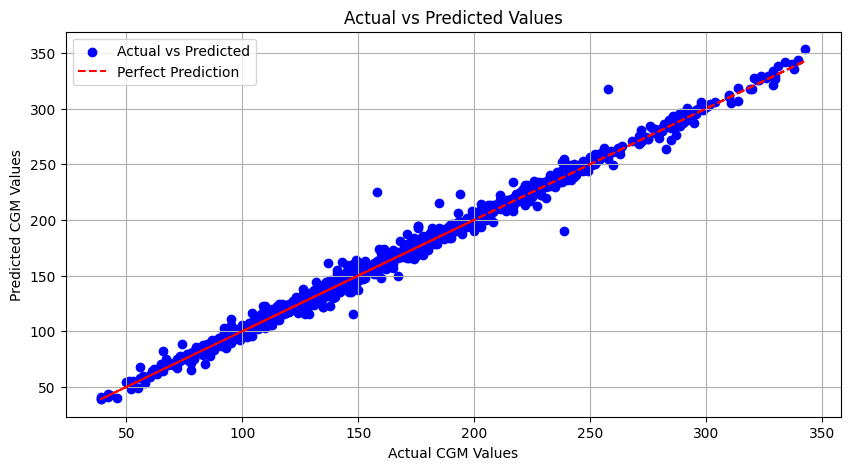

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.scatter(y_test, predictions, color='blue', label='Actual vs Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Perfect Prediction')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual CGM Values')
plt.ylabel('Predicted CGM Values')
plt.legend()
plt.grid(True)
plt.show()


TIME SERIES FORECASTING USING GRU

Results:  Test Loss: 26.650907516479492 ; Test MAE: 4.688020839691162

In [ ]:

from tensorflow.keras.layers import LSTM, Dense, GRU
import tensorflow.keras.backend as K

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model = Sequential([
    GRU(units=100, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True),
    GRU(units=100),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=[root_mean_squared_error])

history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test))

loss, mae = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)

predictions = model.predict(X_test)

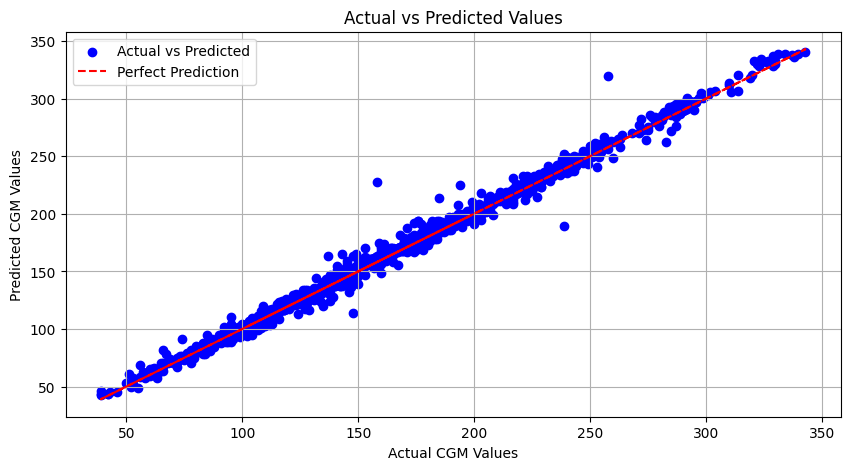

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.scatter(y_test, predictions, color='blue', label='Actual vs Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Perfect Prediction')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual CGM Values')
plt.ylabel('Predicted CGM Values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

order = (5, 1, 0)
model = ARIMA(train, order=order)

model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

rmse = sqrt(mean_squared_error(test, predictions))
print("Test RMSE:", rmse)


FORECASTING USING ARIMA

Results after hyperparameter tuning: Best RMSE: 60.209222905098855
Best Parameters: (4, 0, 4)

In [ ]:
import itertools
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
p_range = range(3, 6)
d_range = range(0, 1)
q_range = range(3, 6)

parameter_combinations = list(itertools.product(p_range, d_range, q_range))

best_rmse = float('inf')
best_params = None

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for params in parameter_combinations:
    try:
        model = ARIMA(y_train, order=params)
        model_fit = model.fit()


        predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')


        rmse = sqrt(mean_squared_error(y_test, predictions))


        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    except:
        continue

print("Best RMSE:", best_rmse)
print("Best Parameters:", best_params)
